# Интересное про python

## Скорость Numpy

NDArray работает в разы быстрее благодаря способу хранения информации

In [480]:
import pandas as pd

In [481]:
a = [1, 2, 3, 300]

for i in range(len(a)-1):

    print(i, id(a[i]))
    print(i+1, id(a[i+1]))
    print('delta', id(a[i+1]) - id(a[i]))
    print('--')

0 140705042147768
1 140705042147800
delta 32
--
1 140705042147800
2 140705042147832
delta 32
--
2 140705042147832
3 1900037269104
delta -138805004878728
--


Python использует хитрые оптимизации и кэширует целые числа от -5 до 256 в **непрерывной** области памяти

In [482]:
id(256) - id(0), id(257) - id(0)

(8192, -138805004881576)

При повторном вызове строчки выше, мы получим другое значение во втором элементе ответа, так как python заново создаст объект 257 где-то в куче и расстояние между ним и объектом 0 уже будет другое

In [483]:
id(256) - id(0), id(257) - id(0)

(8192, -138805004874760)

## display()

In [484]:
a = [1, 2, 3]
b = a
del a
print(b)
# print(a)

[1, 2, 3]


In [485]:
a = [1, 2, 3]
b = a
b[0] = 10
print(a)

[10, 2, 3]


In [486]:
a = [1, 2, 3]
b = a[:]
b[0] = 10
print(a)

[1, 2, 3]


In [487]:
a = [2, 4, 6]
a

[2, 4, 6]

In [488]:
a

[2, 4, 6]

In [489]:
# Обновляем куда указывает имя "a", по хорошему старые данные должны затереться
a = [3, 5, 7]

In [490]:
# Так как в IPython есть специальный массив куда сказываются аутпуты ячеек,
# то старое содержимое "a" никуда не делось и всё равно весит в памяти
# Out[144]

In [491]:
df = pd.DataFrame()

In [492]:
df

""


In [493]:
# df.drop(colums=['a'], inplace=True)

In [494]:
display([1, 2, 3])

[1, 2, 3]

# Урок 3. Классификация

In [495]:
import numpy as np
import pandas as pd

## Смотрим на данные

In [496]:
# Качаем данные
# !gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

Датасет заявок на кредит с информацией о клиента и флагом одобрение или отказ по заявке

In [497]:
#Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [498]:
# Посмотрим на него
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [499]:
df.head(10)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


In [500]:
import seaborn as sns
import matplotlib.pyplot as plt

In [501]:
# Заведём константу, чтобы каждый раз не вспоминать как называется колонка с таргетом
TARGET = 'loan_status'

In [502]:
# Посмотрим на пропуски
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [503]:
df['age_bin'] = df['person_age'] #//6

<Axes: xlabel='age_bin'>

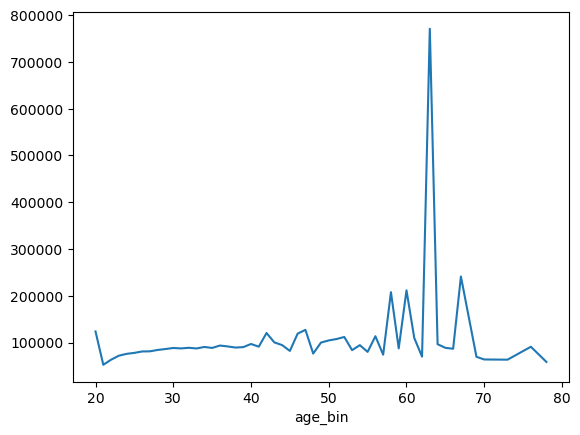

In [504]:
# Посмотрим на распределение среднего дохода в зависимости от возраста
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

<Axes: xlabel='age_bin'>

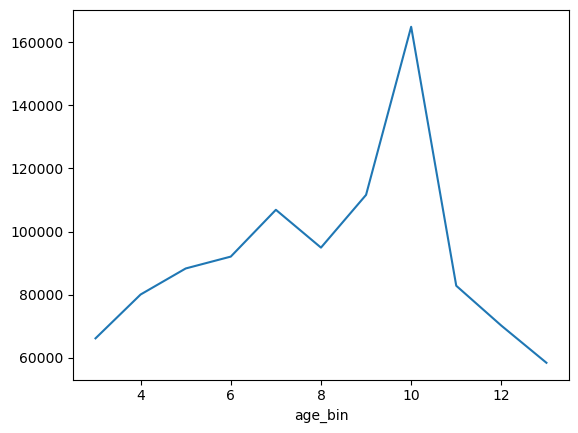

In [505]:
df['age_bin'] = df['person_age'] // 6
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

Пропусков нет - скучно :(

In [506]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [507]:
df.isna().sum()


person_age                         994
person_gender                        0
person_education                     0
person_income                     3000
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
age_bin                              0
dtype: int64

In [508]:
# Проверим гипотезы про случайность/неслучайность получившихся пустот

print('Target rate all:', df[TARGET].mean())

print('--'*20)

print('Target rate income null:', df[df['person_income'].isna()][TARGET].mean())
print('Target rate income not null:', df[df['person_income'].notna()][TARGET].mean())

print('--'*20)

print('Target rate age null:', df[df['person_age'].isna()][TARGET].mean())
print('Target rate age not null:', df[df['person_age'].notna()][TARGET].mean())

Target rate all: 0.2222222222222222
----------------------------------------
Target rate income null: 0.17366666666666666
Target rate income not null: 0.2256904761904762
----------------------------------------
Target rate age null: 0.2112676056338028
Target rate age not null: 0.22246966322774167


## Попробуем обучить LogisticRegression

In [509]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [510]:
# Разобъем на тренировочную и тестовую выборки
train, test = train_test_split(df, test_size=0.25, random_state=43)

In [511]:
# Для простоты возьмём несколько числовых колонок в качестве факторов
features = ['loan_amnt', 'loan_int_rate'] # loan_amnt - сумма кредита, loan_int_rate - процентная ставка

In [512]:
X_train = train[features]
y_train = train[TARGET] #loan status - статус кредита (наш таргет)

X_test = test[features]
y_test = test[TARGET]

In [513]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [514]:
def least_squared_estimator(X, y, learn_intercept=False):
  X = np.array(X)
  if learn_intercept:
    X = np.concatenate([np.ones((X.shape[0], 1), ), X ], axis=1)
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y
  return coefs

In [515]:
coefs = least_squared_estimator(X_train, y_train, learn_intercept=True)
f = lambda x: coefs[0] + coefs[1] * x[:, 0] + coefs[2] * x[:, 1]

print(f)

<function <lambda> at 0x000001BA5D73BCE0>


In [516]:
coefs

array([-3.15807260e-01,  4.23973811e-06,  4.52734577e-02])

In [517]:
train['predict'] = lr.predict(X_train)
test['predict'] = lr.predict(X_test)


train['predict_proba'] = lr.predict_proba(X_train)[:, 1]
test['predict_proba'] = lr.predict_proba(X_test)[:, 1]

In [518]:
train['predict_naive'] = f(X_train.values)
test['predict_naive'] = f(X_test.values)

In [519]:
import matplotlib as mpl

train_sample = train.sample(2500)
test_sample = test.sample(2500)

print(train_sample)

       person_age person_gender person_education  person_income  \
43348        28.0        female      High School        41205.0   
38054        25.0        female        Associate        70370.0   
26850        27.0        female         Bachelor            NaN   
11079        23.0          male        Associate        58534.0   
30660        37.0          male      High School        72995.0   
...           ...           ...              ...            ...   
8035         26.0        female        Associate        67233.0   
11983         NaN          male        Associate        94631.0   
37166        29.0        female         Bachelor        53500.0   
23040        32.0          male           Master        55164.0   
43026        31.0        female         Bachelor        76215.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
43348               4                  RENT    14000.0  DEBTCONSOLIDATION   
38054               2              MORTGA

Посмотрим как мы попали на Train

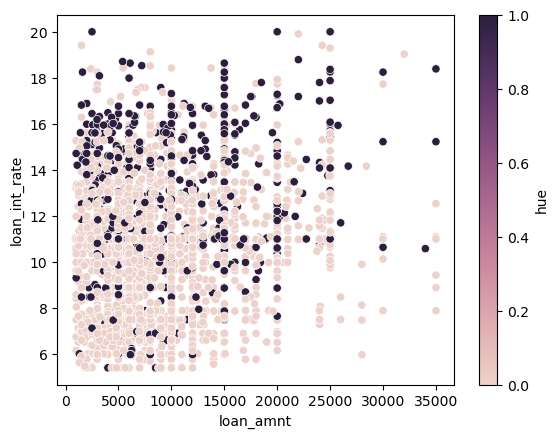

In [520]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

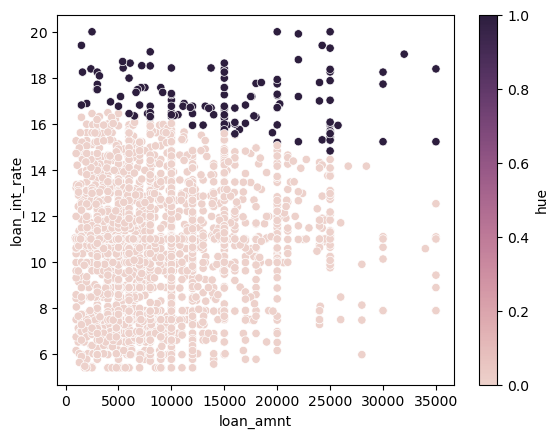

In [521]:
#плохой способ, predict 0,5
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

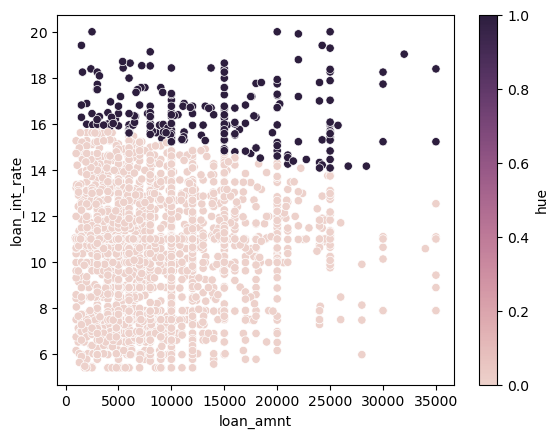

In [522]:
#хороший способ, порог настраиваем сами
train_sample['new_predict'] = (train_sample['predict_proba'] > 0.44).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

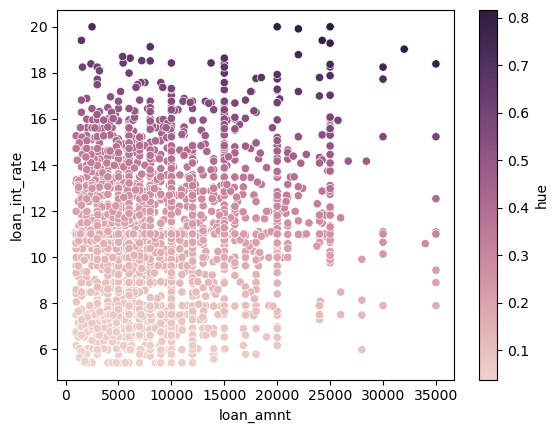

In [523]:
#градиент цвета, норм подход
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

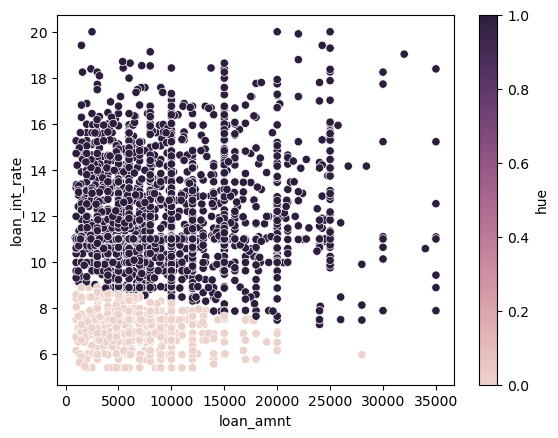

In [524]:
#наивный подход 
train_sample['new_predict'] = (train_sample['predict_naive'] > 0.1).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

Посмотрим как мы попали на Test

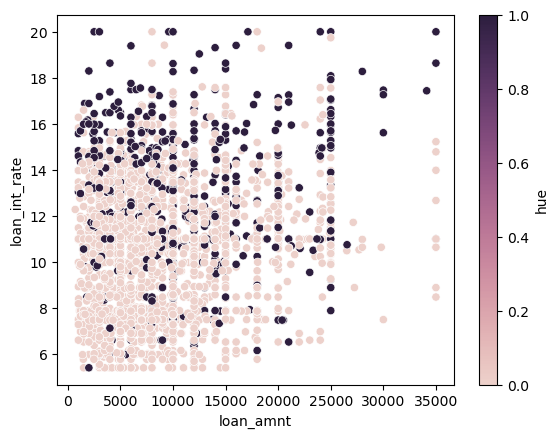

In [525]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

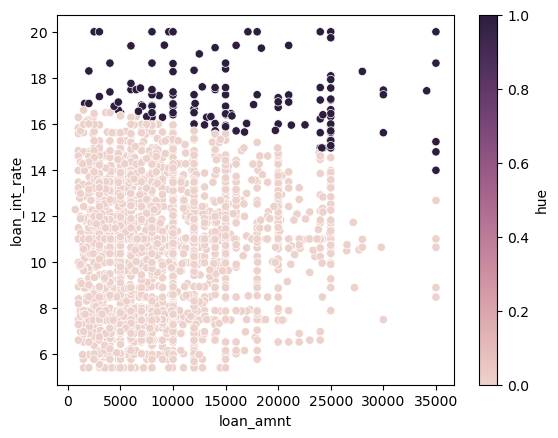

In [526]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

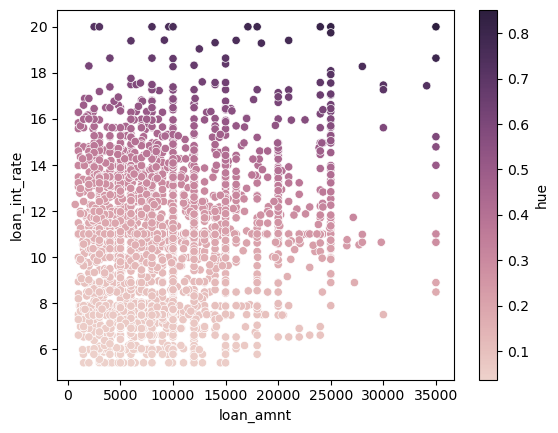

In [527]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

### Посчитаем Метрики

In [528]:
# Для начала заимпортим их
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

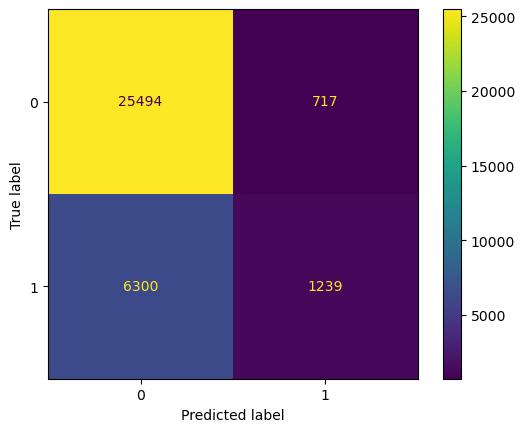

In [529]:
# Нарисуем Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(train[TARGET], train['predict'])).plot()

Верхняя левая (25494):
Истинный класс: 0
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 0, и модель правильно предсказала их как класс 0. Это Истинно Отрицательные (True Negatives, TN). Модель молодец.

Верхняя правая (717):
Истинный класс: 0
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 0, но модель ошибочно предсказала их как класс 1. Это Ложно Положительные (False Positives, FP), или "ошибка I рода". Модель ошиблась.

Нижняя левая (6300):
Истинный класс: 1
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 1, но модель ошибочно предсказала их как класс 0. Это Ложно Отрицательные (False Negatives, FN), или "ошибка II рода". Модель ошиблась (возможно, это самая критичная ошибка, если класс 1 - это что-то важное, например, болезнь).

Нижняя правая (1239):
Истинный класс: 1
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 1, и модель правильно предсказала их как класс 1. Это Истинно Положительные (True Positives, TP). Модель молодец.

In [530]:
# train
accuracy_score(train[TARGET], train['predict'])

0.7920888888888888

In [531]:
# train
accuracy_score(train[TARGET], [0] * train.shape[0])

0.7766222222222222

In [532]:
# test
accuracy_score(test[TARGET], test['predict'])

0.7953777777777777

In [533]:
accuracy_score(train[TARGET], (train['predict_proba'] > 0.44).astype(int))

0.7988740740740741

In [534]:
# train
precision_score(train[TARGET], train['predict'])

0.6334355828220859

In [535]:
# test
precision_score(test[TARGET], test['predict'])

0.6276083467094703

In [536]:
# train
recall_score(train[TARGET], train['predict'])

0.16434540389972144

In [537]:
# test
recall_score(test[TARGET], test['predict'])

0.1588785046728972

In [538]:
# train
roc_auc_score(train[TARGET], train['predict'])

0.5684952382895654

In [539]:
# test
roc_auc_score(test[TARGET], test['predict'])

0.5662409362595342

In [540]:
# train
roc_auc_score(train[TARGET], train['predict_proba'])

0.7223131917050427

In [541]:
# test
roc_auc_score(test[TARGET], test['predict_proba'])

0.7181920078610324

In [542]:
roc_auc_score(train[TARGET], train['predict_naive'])

0.7224718164513158

In [543]:
roc_auc_score(test[TARGET], test['predict_naive'])

0.7181826688628414

In [544]:
from tqdm.auto import tqdm
stats = []
for threshold in tqdm(np.linspace(0.01, 1, 100)):
    stats.append({
        'threshold': threshold,
        'accuracy': accuracy_score(train[TARGET], (train['predict_proba'] > threshold).astype(int)),
        'accuracy_naive': accuracy_score(train[TARGET], (train['predict_naive'] > threshold).astype(int)),
        'precision': precision_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'precision_naive': precision_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
        'recall': recall_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'recall_naive': recall_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
    })
stats = pd.DataFrame(stats)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='threshold', ylabel='accuracy'>

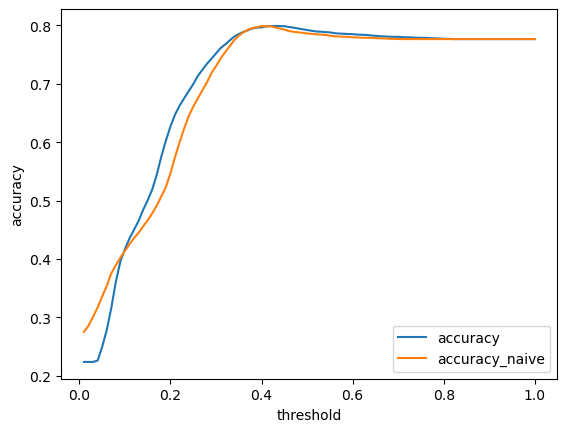

In [545]:
sns.lineplot(data=stats, x='threshold', y='accuracy', label='accuracy')
sns.lineplot(data=stats, x='threshold', y='accuracy_naive',  label='accuracy_naive')

<Axes: xlabel='threshold', ylabel='precision'>

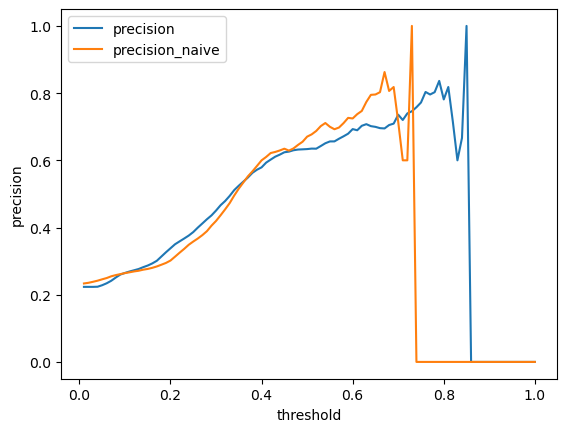

In [546]:
sns.lineplot(data=stats, x='threshold', y='precision', label='precision')
sns.lineplot(data=stats, x='threshold', y='precision_naive',  label='precision_naive')

<Axes: xlabel='threshold', ylabel='recall'>

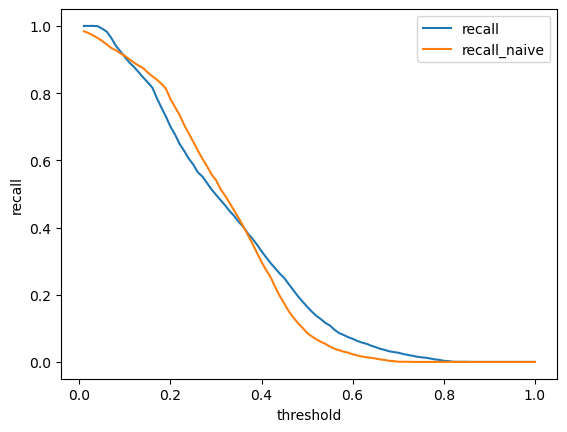

In [547]:
sns.lineplot(data=stats, x='threshold', y='recall', label='recall')
sns.lineplot(data=stats, x='threshold', y='recall_naive',  label='recall_naive')

### Таргет рейт в бинах скоров модели (калибровка)

In [548]:
# Посчитаем равномерные бины по скору на train
_, bins = pd.qcut(train['predict_proba'], q=20, retbins=True)

# Пременим их к train и test
train['proba_bin'] = pd.cut(train['predict_proba'], bins=bins)
test['proba_bin'] = pd.cut(test['predict_proba'], bins=bins)

In [549]:
# Внутри бинов посчитаем средний таргет и среднюю predict_proba
train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
display(train_stats)

C:\Users\evoni\AppData\Local\Temp\ipykernel_17476\2213546392.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


,predict_proba,loan_status
proba_bin,,
"(0.0377, 0.0567]",0.048403,0.060534
"(0.0567, 0.068]",0.062784,0.086002
"(0.068, 0.0776]",0.073074,0.090372
"(0.0776, 0.0884]",0.082339,0.089994
"(0.0884, 0.106]",0.096756,0.138361
"(0.106, 0.129]",0.117001,0.137173
"(0.129, 0.149]",0.139000,0.140828
"(0.149, 0.166]",0.158549,0.145294
"(0.166, 0.178]",0.171868,0.172146


In [550]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Create a base model and fit it first
base_model = LogisticRegression()
base_model.fit(train[['predict_proba']], train[TARGET])

# Create a calibration model with the fitted estimator
calibration = CalibratedClassifierCV(estimator=base_model, cv='prefit')
# Fit the calibration model
calibration.fit(train[['predict_proba']], train[TARGET])

# Use the calibrated model to predict probabilities
train['predict_proba_calib'] = calibration.predict_proba(train[['predict_proba']])[:, 1]
test['predict_proba_calib'] = calibration.predict_proba(test[['predict_proba']])[:, 1]

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

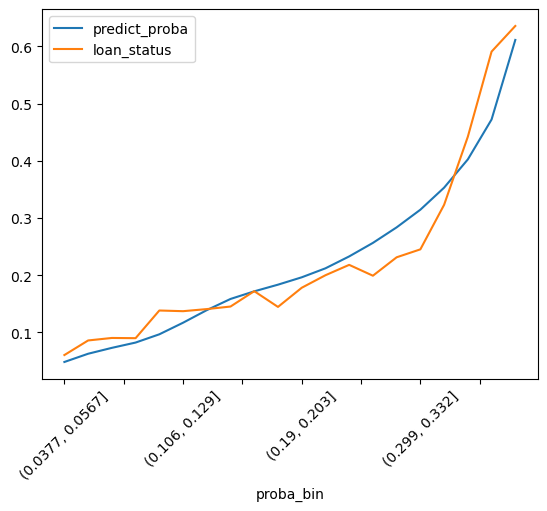

In [551]:
train_stats.plot()
plt.xticks(rotation=45)

C:\Users\evoni\AppData\Local\Temp\ipykernel_17476\1045931144.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

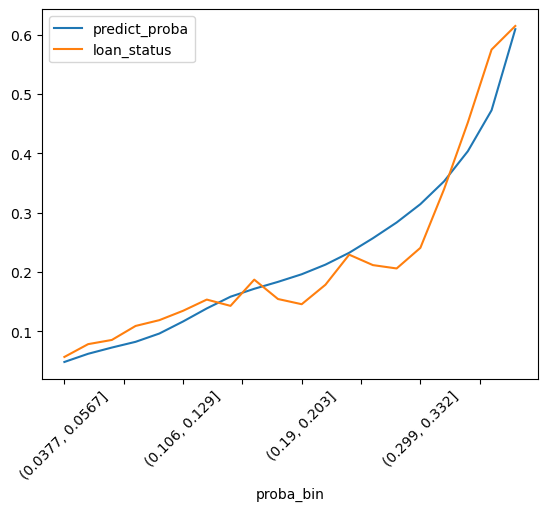

In [552]:
valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
valid_stats.plot()
plt.xticks(rotation=45)

# Домашнее Задание

In [553]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

## Logistic Regression (Своими Силами)

1. Дописать код градиентного спуска ниже
2. Поиграться с датасетом, предложеннным выше
3. Построить свою версию Логистической регресии (на каком-то одном числовом факторе без пропусков), сравнить результаты с LogisticRegression из SKlearn (Оценить метрики - ROC AUC, подобрать порог и Построить Confusion Matrix, а так же производные метрики от неё )
4. Заполнить пропуски, обработать категориальные переменные, обучить свою версию модели и Logistic Regression, сравнить качество между ними (см п.3) + с моделями из п.3 (как добавление бОльшего количества факторов влияет на качество модели)
5. *Поиграться с нормировкой данных (sklearn.model_selection.StandardScaler) оценить эффект на веса модели и её качество
6. Разбить факторы на Клиентские/Продуктовые/Кредитная История и построить по одной модели на каждом факторе. Затем построить мета-модель (интегральная модель) на трёх факторах - скорах метамоделях (дрейверы) - Сравнить результаты по каждому из драйеров + интегральной модели с одной моделью на всём факторном прстранстве.
7. *Привести график качества (ROC AUC) модели на фиксированной тренировочной выборке в зависимости от количества наблюдений, которые используются при обучении (train выборка). Например: 100, 500, 1000 и тд.

*- задания со звёздочкой, не обязательно, но довольно интересные

In [554]:
def sigmoid(z):
    return (1+np.exp(-z))**-1

def logloss(w, X, y):
    return np.log2(1 + np.exp(-(X @ w)*y)).mean()

In [555]:
# Реализуем собственный класс логистической регрессии
class MyLogisticRegression:
    def __init__(self, lr=1e-4, bias=True):
      self.bias = bool(bias)
      self.weights = None
      self.lr = lr

    def preproc_x(self, X):
      # Добавляем bias если требуется
      return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

    def fit(self, X, y, c_epoch=1000):
      # Инициализируем веса
      self.weights = np.ones(X.shape[1]+self.bias)

      self.X = self.preproc_x(X)
      self.y = y


      # Стохастический градиентный спуск
      # Итерируемся по количеству эпох
      for i in range(c_epoch):
        # Перешмешиваем наблюдения случайным образом
        ids = list(range(self.X.shape[0]))
        np.random.shuffle(ids)

        # итерируемся по наблюдениям
        for j in ids:
          p = sigmoid(np.dot(self.X[j], self.weights))
          # !TODO: Реализовать самостоятельно
          self.weights += self.lr * (self.y[j] - p) * self.X[j]

        print(i , ':', logloss(self.weights, self.X, self.y))

    def predict_proba(self, X):
      X = self.preproc_x(X)
      return sigmoid((X @ self.weights)*1)

    def predict(self, X, threshold = 0.5): 
      # X = self.preproc_x(X)
      # preds = (sigmoid((X @ self.weights)*1) > 0.5).astype(int)
      # preds[preds == 0] = -1
      probs = self.predict_proba(X)
      
      return (probs > threshold).astype(int)

In [556]:
# Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [557]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [558]:
# Разбить на train и test выборки
from sklearn.impute import SimpleImputer

train_imputed = train.copy()
test_imputed = test.copy()

### Независимые переменные (Features) + const strings

In [ ]:
# features = ['loan_amnt', 'loan_int_rate']
feature_1 = 'loan_percent_income'
feature_2 = 'credit_score'
features = [feature_1, feature_2]

# CONST STRING
MY_PREDICT = 'my_predict'
MY_PREDICT_PROBA = 'my_predict_proba'

MY_NRML_PREDICT = 'my_nrml_predict'
MY_NRML_PREDICT_PROBA = 'my_nrml_predict_proba'

MY_SCALED_PREDICT = 'my_scaled_predict'
MY_SCALED_PREDICT_PROBA= 'my_scaled_proba'

SK_SCALED_PREDICT = 'sk_scaled_predict'
SK_SCALED_PERDICT_PROBA = 'sk_scaled_proba'

SKLEARN_PREDICT = 'sk_predict'
SKLEARN_PREDICT_PROBA = 'sk_predict_proba'

In [560]:
X_train = train_imputed[features].values
y_train = train_imputed[TARGET].values
X_test = test_imputed[features].values
y_test = test_imputed[TARGET].values

## Параметры модели MyLogisticRegression (с зашумленными данными)

In [634]:
# CONST 
LR = 0.001 
C_EPOCH = 10
THRESHOLD= 0.65

# 1-ая версия
my_lr = MyLogisticRegression(LR)
my_lr.fit(X_train, y_train, C_EPOCH)

0 : 41.500565806159756
1 : 45.37429754690421
2 : 82.77033359919764
3 : 36.62619045063352
4 : 137.92642993442513
5 : 0.7766222222222222
6 : 101.81421934151116
7 : 62.23576445138965
8 : 53.77710174468735
9 : 46.36308569581377


Влияние параметров `lr` и `c_epoch`

- **`lr` (learning rate)**: Это скорость обучения модели. Чем больше значение `lr`, тем быстрее модель обновляет свои веса. Однако слишком большое значение может привести к нестабильности обучения (модель может не сойтись), а слишком маленькое — к очень медленному обучению.

- **`c_epoch` (number of epochs)**: Это количество эпох, за которые модель проходит через весь тренировочный набор данных. Большее количество эпох позволяет модели лучше подстроиться под данные, но может привести к переобучению, если модель слишком долго обучается.

In [635]:
sk_lr = LogisticRegression(max_iter=1000)
sk_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [636]:
train_imputed[MY_PREDICT] = my_lr.predict(X_train, threshold=THRESHOLD)
train_imputed[MY_PREDICT_PROBA] = my_lr.predict_proba(X_train)
test_imputed[MY_PREDICT] = my_lr.predict(X_test, threshold=THRESHOLD)
test_imputed[MY_PREDICT_PROBA] = my_lr.predict_proba(X_test)

train_imputed[SKLEARN_PREDICT] = sk_lr.predict(X_train)
train_imputed[SKLEARN_PREDICT_PROBA] = sk_lr.predict_proba(X_train)[:, 1]
test_imputed[SKLEARN_PREDICT] = sk_lr.predict(X_test)
test_imputed[SKLEARN_PREDICT_PROBA] = sk_lr.predict_proba(X_test)[:, 1]

**my_predict:** Это бинарные предсказания модели (0 или 1), которые используются для классификации объектов.
Например, если вероятность принадлежности к классу 1 (my_predict_proba) больше 0.5, то объект классифицируется как 1, иначе как 0.
Используется для оценки метрик, таких как accuracy, precision, recall, confusion matrix.


**my_predict_proba:**
Это вероятности принадлежности объекта к положительному классу (обычно класс 1).
Используются для более тонкого анализа, например:
Построение ROC-кривой и вычисление ROC AUC.
Настройка порога классификации (например, вместо 0.5 можно выбрать 0.6 для повышения precision).
Калибровка вероятностей (например, с помощью Platt Scaling или Isotonic Regression).


Logistic Regression — это метод машинного обучения, который используется для классификации.

1. **Цель**: Определить вероятность принадлежности объекта к определённому классу (например, 0 или 1).

2. **Как работает**:
   - Модель берёт входные данные (факторы) и умножает их на веса.
   - Затем добавляется смещение (bias).
   - Результат пропускается через функцию **сигмоида**, которая преобразует его в вероятность (значение от 0 до 1).

3. **Решение**:
   - Если вероятность больше 0.5, модель предсказывает класс 1.
   - Если меньше, то класс 0.

4. **Пример**:
   - У вас есть данные о доходе и возрасте человека.
   - Модель предсказывает, одобрить ли кредит (1) или отказать (0).

### Сравнение метрик : MyLogReg vs Sk_LogReg

In [637]:
print("MyLogisticRegression weights:", my_lr.weights)
print("Sklearn LogisticRegression weights:", np.append(sk_lr.intercept_, sk_lr.coef_[0]))

MyLogisticRegression weights: [ 1.08558058  5.77875851 -0.22741572]
Sklearn LogisticRegression weights: [-2.71078479e+00  1.01434400e+01 -2.03519088e-04]


In [638]:
metrics = {}
models = ['my', 'sk']

for model in models:
    metrics[model] = {
        'accuracy': accuracy_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'precision': precision_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'recall': recall_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'roc_auc': roc_auc_score(test_imputed[TARGET], test_imputed[f'{model}_predict_proba'])
    }

metrics_df = pd.DataFrame(metrics).T
print("\nMetrics comparison:")
print(metrics_df)


Metrics comparison:
    accuracy  precision    recall   roc_auc
my  0.781244   0.000000  0.000000  0.517886
sk  0.811022   0.689266  0.247867  0.728807


c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Сравнение матриц ошибок для моделей

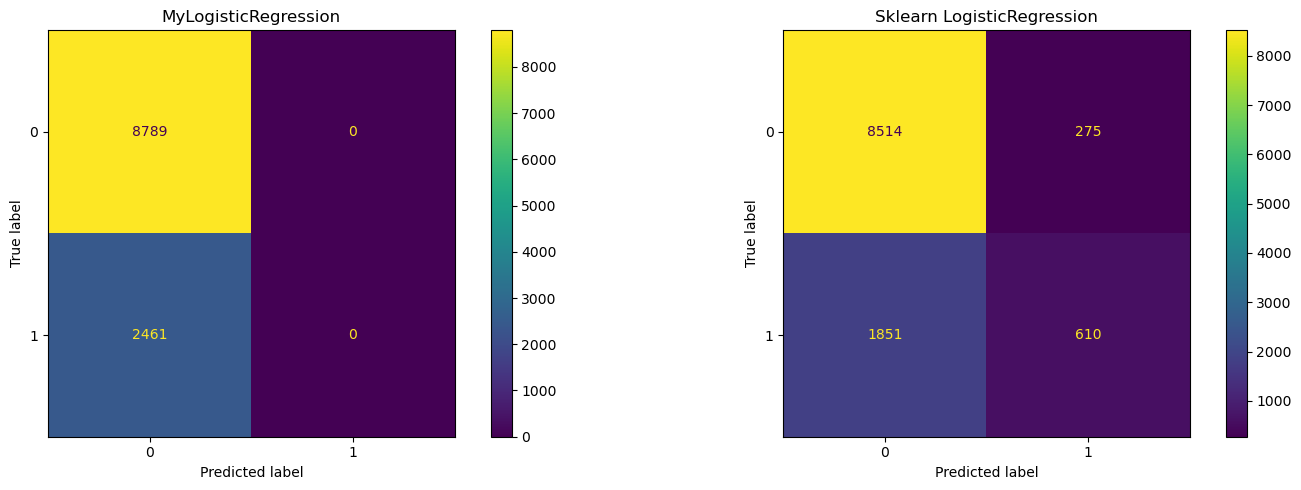

In [639]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed[MY_PREDICT])).plot(ax=axes[0])
axes[0].set_title('MyLogisticRegression')
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed[SKLEARN_PREDICT])).plot(ax=axes[1])
axes[1].set_title('Sklearn LogisticRegression')
plt.tight_layout()
plt.show()

### Распределения вероятностей

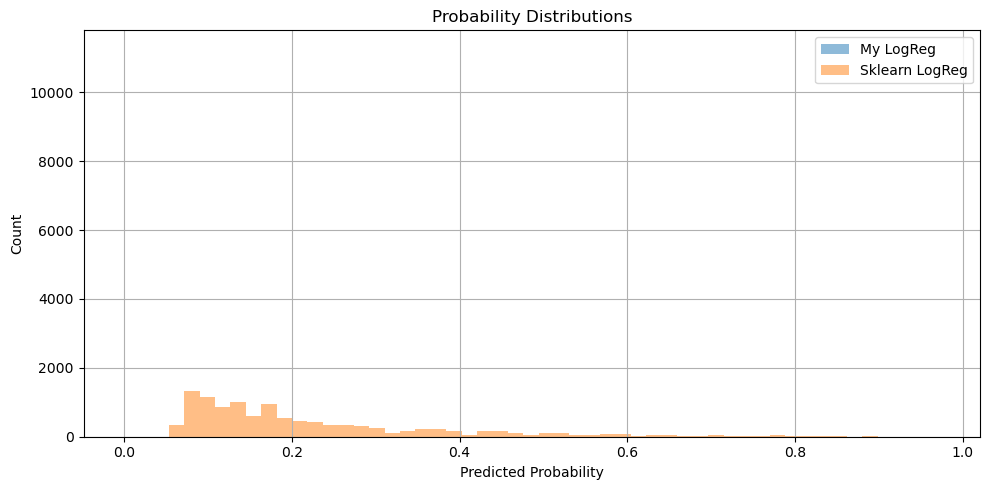

In [640]:
plt.figure(figsize=(10, 5))
plt.hist(test_imputed[MY_PREDICT_PROBA], bins=50, alpha=0.5, label='My LogReg')
plt.hist(test_imputed[SKLEARN_PREDICT_PROBA], bins=50, alpha=0.5, label='Sklearn LogReg')
plt.title('Probability Distributions')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

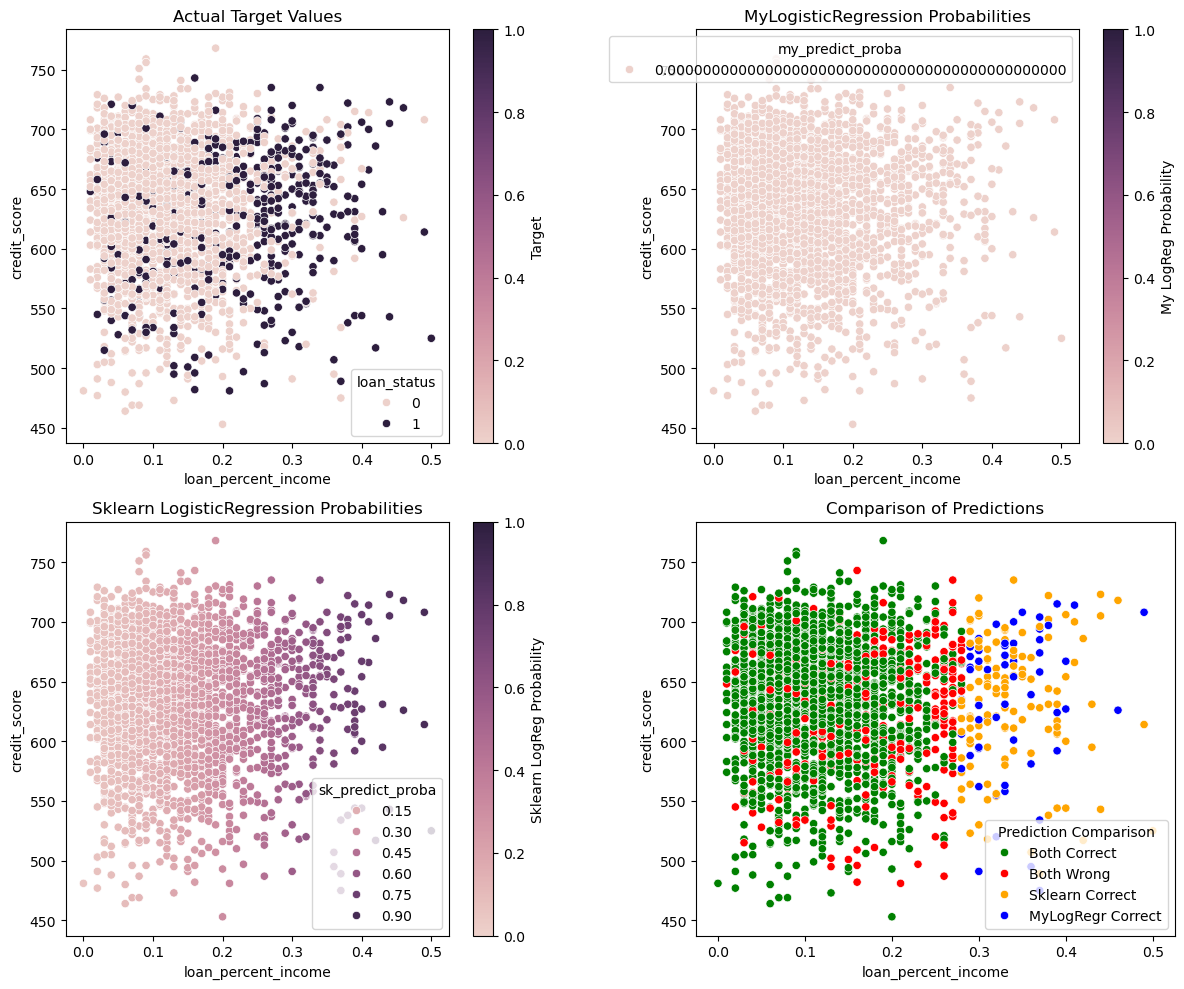

In [641]:
# иногда визуальные деффекты 
test_sample = test_imputed.sample(2500)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
cmap = sns.color_palette('ch:', as_cmap=True)
import matplotlib.colors as mcolors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize())
scatter = sns.scatterplot(data=test_sample, x=feature_1, y=feature_2, hue=TARGET, 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('Target')
plt.title('Actual Target Values')

plt.subplot(2, 2, 2)
scatter = sns.scatterplot(data=test_sample, x=feature_1, y=feature_2, hue=MY_PREDICT_PROBA, 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('My LogReg Probability')
plt.title('MyLogisticRegression Probabilities')

plt.subplot(2, 2, 3)
scatter = sns.scatterplot(data=test_sample, x=feature_1, y=feature_2, hue=SKLEARN_PREDICT_PROBA, 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('Sklearn LogReg Probability')
plt.title('Sklearn LogisticRegression Probabilities')

# Сравнение бинарных предсказаний
plt.subplot(2, 2, 4)
test_sample['my_predict_threshold'] = (test_sample[MY_PREDICT_PROBA] > 0.5).astype(int)
test_sample['comparison'] = np.where(
    (test_sample['my_predict_threshold'] == test_sample[SKLEARN_PREDICT]) & 
    (test_sample['my_predict_threshold'] == test_sample[TARGET]), 
    'Both Correct', 
    np.where(
        (test_sample['my_predict_threshold'] != test_sample[SKLEARN_PREDICT]) & 
        (test_sample['my_predict_threshold'] == test_sample[TARGET]), 
        'MyLogRegr Correct', 
        np.where(
            (test_sample['my_predict_threshold'] != test_sample[SKLEARN_PREDICT]) & 
            (test_sample[SKLEARN_PREDICT] == test_sample[TARGET]), 
            'Sklearn Correct', 
            'Both Wrong'
        )
    )
)
scatter = sns.scatterplot(data=test_sample, x=feature_1, y=feature_2, hue='comparison', 
                         palette={'Both Correct': 'green', 'MyLogRegr Correct': 'blue', 
                                  'Sklearn Correct': 'orange', 'Both Wrong': 'red'})
plt.title('Comparison of Predictions')
plt.legend(title='Prediction Comparison')

plt.tight_layout()
plt.show()

## MyLogisticRegression после стандартизации

In [ ]:
from sklearn.discriminant_analysis import StandardScaler

sclr = StandardScaler()
X_train_scaled = sclr.fit_transform(X_train)
X_test_scaled = sclr.transform(X_test)

#2-ая версия
my_lr_normlalized = MyLogisticRegression(LR)
my_lr_normlalized.fit(X_train_scaled, y_train, C_EPOCH)

# my_lr.fit(X_train_scaled, y_train, C_EPOCH)

0 : 1.1864000356472337
1 : 1.1907330886959435
2 : 1.191414295440594
3 : 1.1869568487182593
4 : 1.191923262204195
5 : 1.1969728594964404
6 : 1.1947898921627942
7 : 1.1889090025055091
8 : 1.1868101630392647
9 : 1.18780966361792


In [643]:
train_imputed[MY_NRML_PREDICT] = my_lr_normlalized.predict(X_train_scaled, threshold = THRESHOLD)
train_imputed[MY_NRML_PREDICT_PROBA] = my_lr_normlalized.predict_proba(X_train_scaled)
test_imputed[MY_NRML_PREDICT] = my_lr_normlalized.predict(X_test_scaled, threshold = THRESHOLD)
test_imputed[MY_NRML_PREDICT_PROBA] = my_lr_normlalized.predict_proba(X_test_scaled)

train_imputed[SKLEARN_PREDICT] = sk_lr.predict(X_train)
train_imputed[SKLEARN_PREDICT_PROBA] = sk_lr.predict_proba(X_train)[:, 1]
test_imputed[SKLEARN_PREDICT] = sk_lr.predict(X_test)
test_imputed[SKLEARN_PREDICT_PROBA] = sk_lr.predict_proba(X_test)[:, 1]

### Обработка пропущенных данных

In [644]:
numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

numeric_imputer = SimpleImputer(strategy='median')

train_imputed[numeric_features] = numeric_imputer.fit_transform(train[numeric_features])
test_imputed[numeric_features] = numeric_imputer.transform(test[numeric_features])

### Сравнение метрик

In [645]:
print("MyLogisticRegression weights:", my_lr.weights)
print("Sklearn LogisticRegression weights:", np.append(sk_lr.intercept_, sk_lr.coef_[0]))

MyLogisticRegression weights: [ 1.08558058  5.77875851 -0.22741572]
Sklearn LogisticRegression weights: [-2.71078479e+00  1.01434400e+01 -2.03519088e-04]


In [646]:
metrics = {}
models = ['my_nrml', 'sk']

for model in models:
    metrics[model] = {
        'accuracy': accuracy_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'precision': precision_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'recall': recall_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'roc_auc': roc_auc_score(test_imputed[TARGET], test_imputed[f'{model}_predict_proba'])
    }

metrics_df = pd.DataFrame(metrics).T
print("\nMetrics comparison:")
print(metrics_df)


Metrics comparison:
         accuracy  precision    recall   roc_auc
my_nrml  0.795733   0.719677  0.108492  0.728339
sk       0.811022   0.689266  0.247867  0.728807


### Сравнение матриц ошибок для моделей

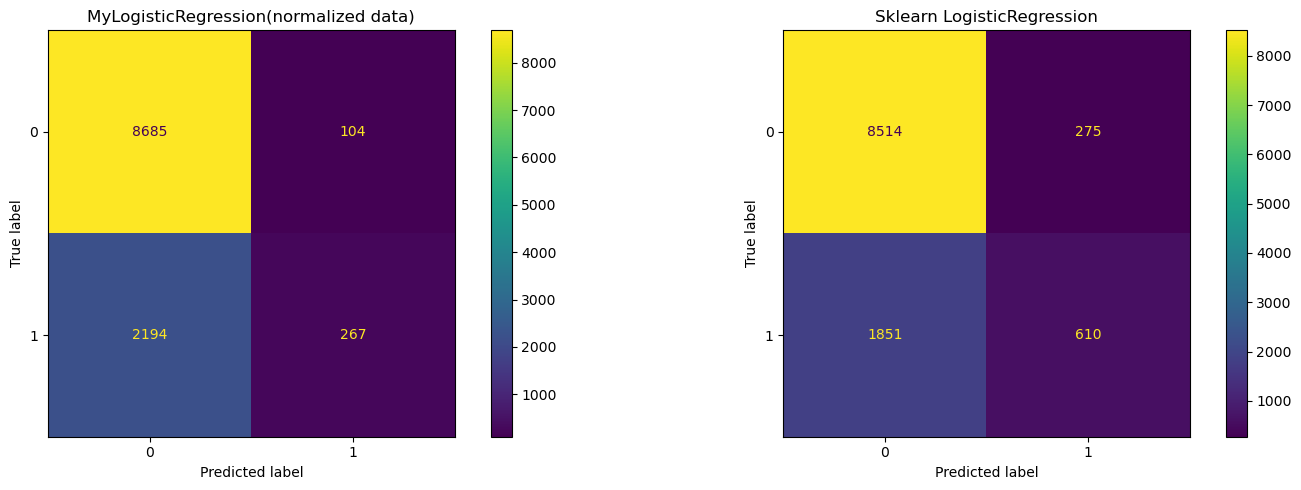

In [647]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed[MY_NRML_PREDICT])).plot(ax=axes[0])
axes[0].set_title('MyLogisticRegression(normalized data)')
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed[SKLEARN_PREDICT])).plot(ax=axes[1])
axes[1].set_title('Sklearn LogisticRegression')
plt.tight_layout()
plt.show()

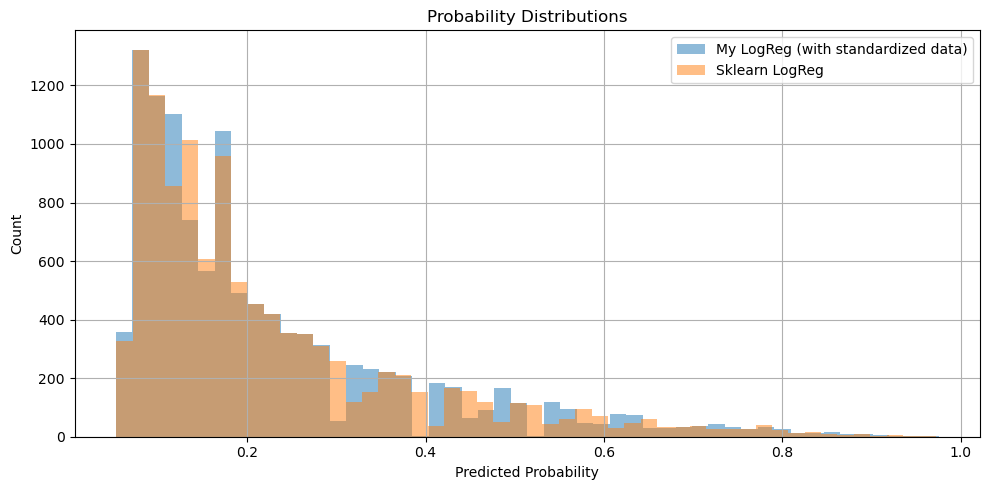

In [648]:
plt.figure(figsize=(10, 5))
plt.hist(test_imputed[MY_NRML_PREDICT_PROBA], bins=50, alpha=0.5, label='My LogReg (with standardized data)')
plt.hist(test_imputed[SKLEARN_PREDICT_PROBA], bins=50, alpha=0.5, label='Sklearn LogReg')
plt.title('Probability Distributions')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [649]:
thresholds = np.linspace(0.01, 0.99, 99)
stats = []

for threshold in thresholds:
    my_pred = (test_imputed[MY_NRML_PREDICT_PROBA] > threshold).astype(int)
    sk_pred = (test_imputed[SKLEARN_PREDICT_PROBA] > threshold).astype(int)
    
    stats.append({
        'threshold': threshold,
        'my_accuracy': accuracy_score(test_imputed[TARGET], my_pred),
        'sk_accuracy': accuracy_score(test_imputed[TARGET], sk_pred),
        'my_precision': precision_score(test_imputed[TARGET], my_pred, zero_division=0),
        'sk_precision': precision_score(test_imputed[TARGET], sk_pred, zero_division=0),
        'my_recall': recall_score(test_imputed[TARGET], my_pred, zero_division=0),
        'sk_recall': recall_score(test_imputed[TARGET], sk_pred, zero_division=0),
    })

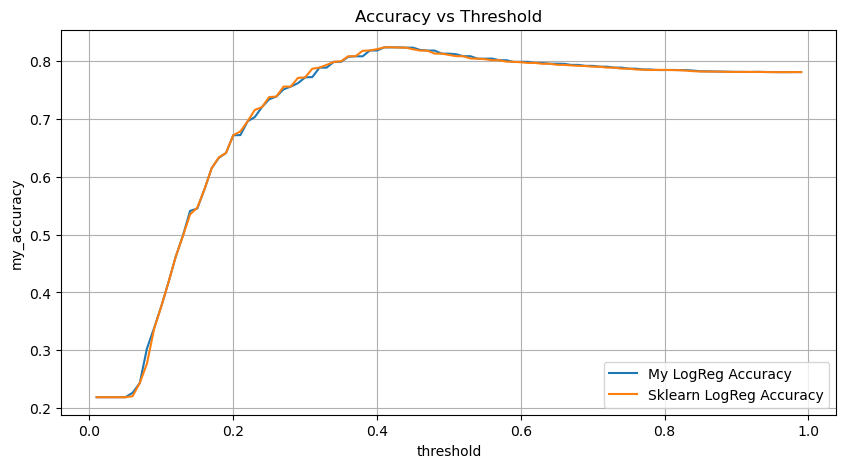

In [650]:
stats_df = pd.DataFrame(stats)

plt.figure(figsize=(10, 5))
sns.lineplot(data=stats_df, x='threshold', y='my_accuracy', label='My LogReg Accuracy')
sns.lineplot(data=stats_df, x='threshold', y='sk_accuracy', label='Sklearn LogReg Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


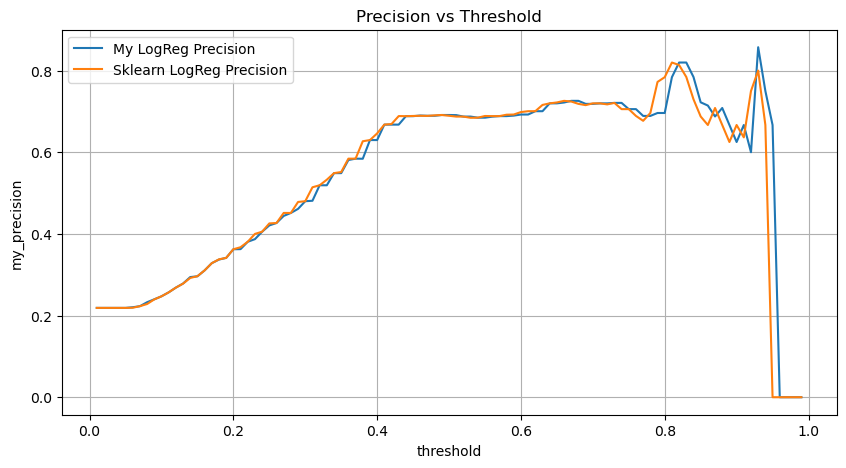

In [651]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=stats_df, x='threshold', y='my_precision', label='My LogReg Precision')
sns.lineplot(data=stats_df, x='threshold', y='sk_precision', label='Sklearn LogReg Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

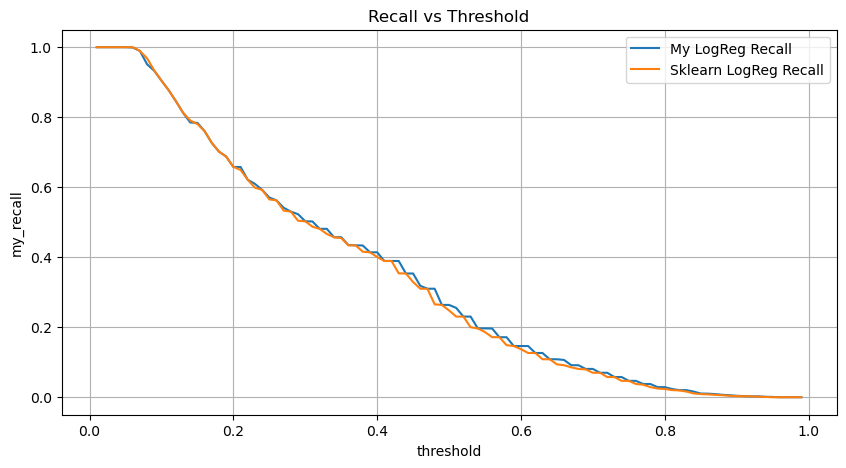

In [652]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=stats_df, x='threshold', y='my_recall', label='My LogReg Recall')
sns.lineplot(data=stats_df, x='threshold', y='sk_recall', label='Sklearn LogReg Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

## Сравниваем разные модели

In [ ]:
NEW_LR = 0.00001
NEW_C_EPOCH = 1000


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3-ая версия
my_lr_scaled = MyLogisticRegression(NEW_LR)
my_lr_scaled.fit(X_train_scaled, y_train, NEW_C_EPOCH)

sk_lr_scaled = LogisticRegression(max_iter=1000)
sk_lr_scaled.fit(X_train_scaled, y_train)

train_imputed[MY_SCALED_PREDICT_PROBA] = my_lr_scaled.predict_proba(X_train_scaled)
test_imputed[MY_SCALED_PREDICT_PROBA] = my_lr_scaled.predict_proba(X_test_scaled)
train_imputed[SK_SCALED_PERDICT_PROBA] = sk_lr_scaled.predict_proba(X_train_scaled)[:, 1]
test_imputed[SK_SCALED_PERDICT_PROBA] = sk_lr_scaled.predict_proba(X_test_scaled)[:, 1]

0 : 0.8930384698777974
1 : 0.9021803470926254
2 : 0.9115687187514853
3 : 0.9211441515523858
4 : 0.9308518482424312
5 : 0.9406260920369053
6 : 0.9504162396311231
7 : 0.9601633047127749
8 : 0.9698242411803966
9 : 0.9793529087520771
10 : 0.9887076043508445
11 : 0.9978579872470836
12 : 1.0067752174272517
13 : 1.0154385749990196
14 : 1.023824900182573
15 : 1.0319255628636612
16 : 1.0397314303280463
17 : 1.0472287792669241
18 : 1.0544193173034284
19 : 1.061300900930841
20 : 1.0678738270880208
21 : 1.074148222345636
22 : 1.0801185901446786
23 : 1.085802985981846
24 : 1.0912057066523142
25 : 1.0963322734634404
26 : 1.1012011240019237
27 : 1.105811244161251
28 : 1.1101820040743342
29 : 1.1143152886018475
30 : 1.118227930872288
31 : 1.1219399333255151
32 : 1.1254361582111374
33 : 1.128750972295998
34 : 1.131884678008675
35 : 1.1348468992597882
36 : 1.1376454262541362
37 : 1.1402902171963705
38 : 1.1427837751422663
39 : 1.1451472176616637
40 : 1.1473860090875685
41 : 1.1494984877498873
42 : 1.151

In [ ]:
print("\nScaled MyLogisticRegression weights:", my_lr_scaled.weights)
print("Scaled Sklearn LogisticRegression weights:", np.append(sk_lr_scaled.intercept_, sk_lr_scaled.coef_[0]))

print("\nROC AUC on original data:")
print("My LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed[MY_PREDICT_PROBA]))
print("Sklearn LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed[SKLEARN_PREDICT_PROBA]))

print("\nROC AUC on scaled data:")
print(f"My LogReg with number of epoch: {C_EPOCH} and with learning rate: {LR} :", roc_auc_score(test_imputed[TARGET], test_imputed[MY_NRML_PREDICT_PROBA]))
print(f"My LogReg with number of epoch: {NEW_C_EPOCH} and with learning rate: {NEW_LR} :", roc_auc_score(train_imputed[TARGET], train_imputed[MY_SCALED_PREDICT_PROBA]))
print("Sklearn LogReg:", roc_auc_score(train_imputed[TARGET], train_imputed[SK_SCALED_PERDICT_PROBA]))


Scaled MyLogisticRegression weights: [-1.43125275  0.90877611 -0.01009481]
Scaled Sklearn LogisticRegression weights: [-1.43111896  0.90859797 -0.01010979]

ROC AUC on original data:
My LogReg: 0.6522036175302982
Sklearn LogReg: 0.7288069813542277

ROC AUC on scaled data:
My LogReg with number of epoch: 10 and with learning rate: 0.001 : 0.7288164590504116
My LogReg with number of epoch: 1000 and with learning rate: 1e-05 : 0.7240015268055655
Sklearn LogReg: 0.7240015268055655


## Клиентские/Продуктовые/Кредитные факторы 

In [ ]:
if 'person_emp_length' not in train_imputed.columns or 'person_emp_length' not in test_imputed.columns:
    train_imputed['person_emp_length'] = train['person_emp_exp'] if 'person_emp_exp' in train.columns else np.nan
    test_imputed['person_emp_length'] = test['person_emp_exp'] if 'person_emp_exp' in test.columns else np.nan

client_features = ['person_age', 'person_income', 'person_emp_length']
product_features = ['loan_percent_income', 'loan_int_rate', 'loan_percent_income']
credit_history_features = ['cb_person_cred_hist_length']

group_models = {}
group_predictions = {}

for group_name, group_features in [
    ('client', client_features),
    ('product', product_features),
    ('credit_history', credit_history_features)
]:
    X_train_group = train_imputed[group_features].values
    X_test_group = test_imputed[group_features].values
    
    scaler = StandardScaler()
    X_train_group_scaled = scaler.fit_transform(X_train_group)
    X_test_group_scaled = scaler.transform(X_test_group)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_group_scaled, y_train)
    
    group_models[group_name] = model
    
    train_imputed[f'{group_name}_predict_proba'] = model.predict_proba(X_train_group_scaled)[:, 1]
    test_imputed[f'{group_name}_predict_proba'] = model.predict_proba(X_test_group_scaled)[:, 1]
    
    # Выводим ROC AUC для группы
    print(f"\nROC AUC for {group_name} features:")
    print(roc_auc_score(test_imputed[TARGET], test_imputed[f'{group_name}_predict_proba']))

meta_features_train = train_imputed[['client_predict_proba', 'product_predict_proba', 'credit_history_predict_proba']].values
meta_features_test = test_imputed[['client_predict_proba', 'product_predict_proba', 'credit_history_predict_proba']].values

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features_train, y_train)

train_imputed['meta_predict_proba'] = meta_model.predict_proba(meta_features_train)[:, 1]
test_imputed['meta_predict_proba'] = meta_model.predict_proba(meta_features_test)[:, 1]

print("\nROC AUC for meta model:")
print(roc_auc_score(test_imputed[TARGET], test_imputed['meta_predict_proba']))

print("\nFinal ROC AUC comparison:")
print("Client features:", roc_auc_score(test_imputed[TARGET], test_imputed['client_predict_proba']))
print("Product features:", roc_auc_score(test_imputed[TARGET], test_imputed['product_predict_proba']))
print("Credit history features:", roc_auc_score(test_imputed[TARGET], test_imputed['credit_history_predict_proba']))
print("Meta model:", roc_auc_score(test_imputed[TARGET], test_imputed['meta_predict_proba']))
print("Full feature space (sklearn):", roc_auc_score(test_imputed[TARGET], test_imputed[SKLEARN_PREDICT_PROBA]))


ROC AUC for client features:
0.6970612761722536

ROC AUC for product features:
0.8146758796654363

ROC AUC for credit_history features:
0.5136789277387617

ROC AUC for meta model:
0.8364039142607843

Final ROC AUC comparison:
Client features: 0.6970612761722536
Product features: 0.8146758796654363
Credit history features: 0.5136789277387617
Meta model: 0.8364039142607843
Full feature space (sklearn): 0.7288069813542277


## График качества (ROC AUC) модели на фиксированной тренировочной выборке в зависимости от количества наблюдений

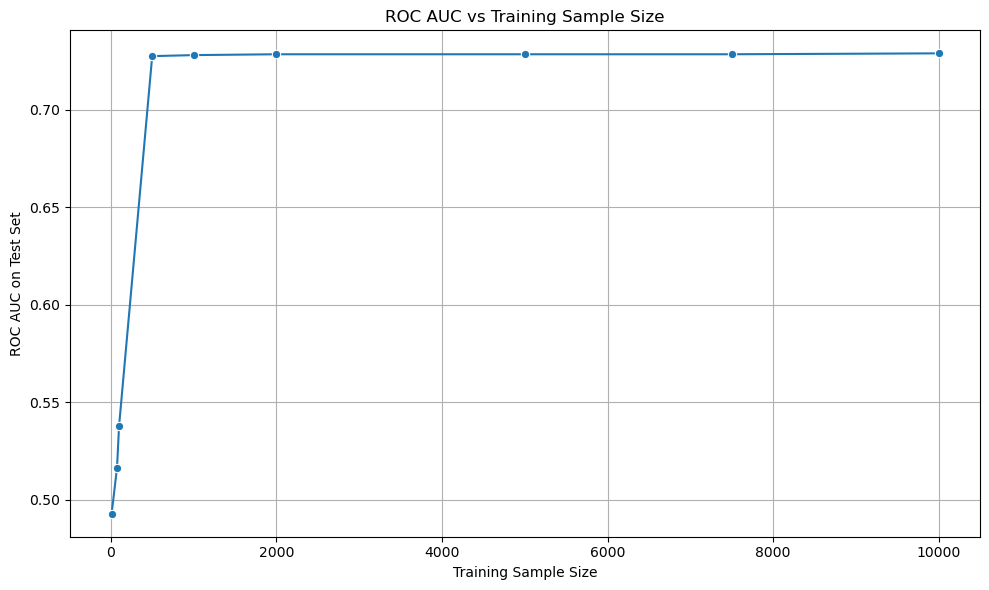

In [ ]:
sample_sizes = [10, 75, 100, 500, 1000, 2000, 5000, 7500, 10000]
roc_auc_scores = []

for size in sample_sizes:
    train_sample = train_imputed.sample(min(size, len(train_imputed)), random_state=42)
    X_train_sample = train_sample[features].values
    y_train_sample = train_sample[TARGET].values
    
    lr_sample = LogisticRegression(max_iter=1000)
    lr_sample.fit(X_train_sample, y_train_sample)

    test_imputed[f'sample_{size}_predict_proba'] = lr_sample.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(test_imputed[TARGET], test_imputed[f'sample_{size}_predict_proba'])
    roc_auc_scores.append({'sample_size': size, 'roc_auc': roc_auc})

roc_auc_df = pd.DataFrame(roc_auc_scores)
plt.figure(figsize=(10, 6))
sns.lineplot(data=roc_auc_df, x='sample_size', y='roc_auc', marker='o')
plt.title('ROC AUC vs Training Sample Size')
plt.xlabel('Training Sample Size')
plt.ylabel('ROC AUC on Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()